# Example of Human Activity Recognition from accelerometer data using traditional feature extraction and machine learning pipeline

This is a brief demo of functions that convert the raw time based accelerometer data and human activity recognition (HAR) labels to trainX, trainy, testX, testy numpy arrays. 
* Builds numpy arrays using load_dataset functions and default arguments
* Builds/Trains/Evaluates a 1D CNN classifier for the selected dataset
* Displays several model evaluation figures and metrics

This example uses the UniMiB SHAR ADL dataset:
http://www.sal.disco.unimib.it/technologies/unimib-shar/

Authors:  Lee B. Hinkle, Vangelis Metsis, IMICS Lab, Texas State University, 2021

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.



In [2]:
#mount google drive in colab session
from google.colab import drive
drive.mount('/content/drive')

#enter path to where the datasets can be found in google drive
my_path = '/content/drive/MyDrive/Academia/Presentations/AIAI2021 - Biosignal analysis tutorial/Data'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Check hardware information (optional)
cpu_model = !grep 'model name' /proc/cpuinfo
header = 'CPU1: ' + cpu_model[0] + '\n'
header += 'CPU2: ' + cpu_model[1] + '\n'
gpu_info = !nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv
header += 'GPU: ' + str(gpu_info[1]) + '\n'
print(header)

CPU1: model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
CPU2: model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
GPU: 



#Imports

In [4]:
import os
import shutil
from scipy import io #for loadmat, matlab conversion
import numpy as np
import matplotlib.pyplot as plt # for plotting training curves
#imports for computing and displaying output metrics
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support

In [5]:
# Tsfresh library (https://tsfresh.readthedocs.io/en/latest/) will be used for extracting features from the raw signals
!pip install tsfresh


In [6]:
# from tsfresh.feature_extraction import feature_calculators as fc
from tsfresh.feature_extraction import settings
from tsfresh import extract_features
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#Get numpy arrays from load_dataset

In [7]:
# Auxiliary functions used to display the shape of the data

def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

def get_shapes(np_arr_list):
    """Returns text, each line is shape and dtype for numpy array in list
       example: print(get_shapes([X_train, X_test, y_train, y_test]))"""
    shapes = ""
    for i in np_arr_list:
        my_name = namestr(i,globals())
        shapes += (my_name[0] + " shape is " + str(i.shape) \
            + " data type is " + str(i.dtype) + "\n")
    return shapes

The following cell uses the auxiliary script unimib_shar_adl_load_dataset.py to download the UniMiB_SHAR dataset from its original source and converts it into
Numpy arrays for easy processing.

In [8]:
dataset = "UniMiB SHAR"
datasetfn = 'mobiact_adl_load_dataset.py'
full_filename = my_path+'/HAR/UniMiB_SHAR/'+'unimib_shar_adl_load_dataset.py'
shutil.copy(full_filename,'unimib_shar_adl_load_dataset.py')

from unimib_shar_adl_load_dataset import unimib_load_dataset
#x_train, y_train, x_test, y_test = unimib_load_dataset(incl_val_group = False)
x_train, y_train, x_validate, y_validate, x_test, y_test = unimib_load_dataset(incl_xyz_accel = True, incl_rms_accel = False, incl_val_group = True, one_hot_encode = False)
t_names = ['StandingUpFS','StandingUpFL','Walking','Running','GoingUpS','Jumping','GoingDownS','LyingDownFS','SittingDown']

print(get_shapes([x_train, y_train, x_validate, y_validate, x_test, y_test]))

Raw data     shape        object type              data type
-----------  -----------  -----------------------  -----------
adl_data:    (7579, 453)  <class 'numpy.ndarray'>  float64
adl_labels:  (7579, 3)    <class 'numpy.ndarray'>  uint8
adl_names:   (9, 1)       <class 'numpy.ndarray'>  object
Reshaped data    shape           object type              data type
---------------  --------------  -----------------------  -----------
adl_data:        (7579, 151, 3)  <class 'numpy.ndarray'>  float64
adl_labels:      (7579, 3)       <class 'numpy.ndarray'>  uint8
adl_names:       (9, 1)          <class 'numpy.ndarray'>  object
x/y_train shape  (4601, 151, 3) (4601,)
x/y_validation shape  (1454, 151, 3) (1454,)
x/y_test shape   (1524, 151, 3) (1524,)
x_train shape is (4601, 151, 3) data type is float64
y_train shape is (4601,) data type is uint8
x_validate shape is (1454, 151, 3) data type is float64
y_validate shape is (1454,) data type is uint8
x_test shape is (1524, 151, 3) data type is 

# Extact hand-engineered features

In [9]:
def find_best_featrues(X, y, fc_parameters=settings.EfficientFCParameters()):
    """
    This function uses the *tsfresh* library to extract features from time series
    data and select the best of them.

    Parameters
    ----------
    X : A pandas dataframe with the following columns:
        columns=["id", "time", "channel_1", "channel_2",..., channel_m]
        All time steps of an instance (sequence) have the same id.
        See details: https://tsfresh.readthedocs.io/en/latest/text/data_formats.html
        
    y : An array of labels, one label per data window.

    Returns
    -------
    features_filtered : A two dimesional array of feature vectors. Each row 
    contains the features extracted from a single sequence window.

    """
    # Feature extraction step. Get DataFrame extracted_features with all more than 1200 different extracted features per channel
    extracted_features = extract_features(X, column_id="id", column_sort="time", default_fc_parameters=fc_parameters)
    
    # remove all NaN values (that were created by feature calculators, than can not be used on the given data, e.g. because it has too low statistics)
    impute(extracted_features)
    
    print('Original dimensionality: %d' %extracted_features.shape[1])

    # Feature selection step. Select only the relevant features.
    #features_filtered = select_features(extracted_features, y)
    features_filtered = extracted_features # We will keep all extracted features 
    print('Reduced dimensionality: %d' %features_filtered.shape[1])
    
    return features_filtered

In [10]:
# Convert training sequences for tsfresh input
# For details on how to use tsfresh for feature extraction see:
# https://tsfresh.readthedocs.io/en/latest/text/quick_start.html
# https://tsfresh.readthedocs.io/en/latest/text/feature_extraction_settings.html
data = []
dim1 = x_train.shape[0]
dim2 = x_train.shape[1]
for i in range(dim1):
    for j in range(dim2):
#         data.append([i, j, x_train[i, j]])

# df_train = pd.DataFrame(data, columns=["id", "time", "acc_total"])
        data.append([i, j, x_train[i, j, 0], x_train[i, j, 1], x_train[i, j, 2]])

df_train = pd.DataFrame(data, columns=["id", "time", "accX", "accY", "accZ"])
print(df_train.head())

# If one hot encoded, convert to integer labels
# y_train = np.argmax(y_train, axis=1)

fc_parameters=settings.MinimalFCParameters() # Extract 9 basic features per channel
# fc_parameters=settings.EfficientFCParameters()
selected_features = find_best_featrues(df_train, y_train, fc_parameters)

train_feat_vectors = selected_features
train_feat_vectors.head()

   id  time      accX      accY      accZ
0   0     0  1.347418  6.976765 -5.972959
1   0     1  1.281786  6.716826 -6.285809
2   0     2  1.303489  6.262892 -5.811090
3   0     3  1.272804  6.568497 -5.855827
4   0     4  1.286611  6.935199 -5.978568


Feature Extraction: 100%|██████████| 5/5 [00:07<00:00,  1.54s/it]


Original dimensionality: 27
Reduced dimensionality: 27


,accX__sum_values,accX__median,accX__mean,accX__length,accX__standard_deviation,accX__variance,accX__root_mean_square,accX__maximum,accX__minimum,accY__sum_values,accY__median,accY__mean,accY__length,accY__standard_deviation,accY__variance,accY__root_mean_square,accY__maximum,accY__minimum,accZ__sum_values,accZ__median,accZ__mean,accZ__length,accZ__standard_deviation,accZ__variance,accZ__root_mean_square,accZ__maximum,accZ__minimum
0,175.589492,0.786752,1.162844,151.0,2.062686,4.254673,2.367885,10.658346,-1.222446,1029.533854,6.792581,6.818105,151.0,1.299063,1.687565,6.940758,15.820220,2.950107,-887.730348,-6.016888,-5.879009,151.0,0.921519,0.849197,5.950793,-2.550903,-10.743757
1,154.241758,0.711499,1.021469,151.0,1.983207,3.933112,2.230809,8.413637,-1.919415,1000.115890,6.581532,6.623284,151.0,1.221116,1.491125,6.734910,16.907171,3.361459,-930.511890,-6.361771,-6.162330,151.0,0.996430,0.992873,6.242370,-2.182096,-11.285851
2,156.771076,0.761128,1.038219,151.0,1.685661,2.841452,1.979735,7.962880,-1.358458,1008.126030,6.573909,6.676331,151.0,1.208857,1.461334,6.784890,17.276079,4.812890,-944.914847,-6.331074,-6.257714,151.0,0.848523,0.719991,6.314980,-3.433229,-12.467138
3,-313.251321,-0.605412,-2.074512,151.0,3.389899,11.491417,3.974295,2.793745,-10.690007,617.259232,4.634456,4.087809,151.0,1.964152,3.857893,4.535204,11.454142,-1.353724,-1062.064022,-8.029828,-7.033537,151.0,2.464855,6.075512,7.452929,0.399958,-15.997587
4,-335.695856,-0.197230,-2.223151,151.0,4.010587,16.084805,4.585543,2.427614,-9.939291,514.786260,4.384562,3.409181,151.0,2.375091,5.641057,4.154945,12.482116,-2.235230,-1019.088941,-8.116615,-6.748933,151.0,2.893458,8.372097,7.343037,0.399958,-16.169073


In [10]:
# Save feature vectors for future use to save time from having to recalculate them
train_feat_vectors.to_pickle(my_path+'/HAR/UniMiB_SHAR/train_feat_vectors.pkl')

In [11]:
# train_feat_vectors = pd.read_pickle(my_path+'/HAR/UniMiB_SHAR/train_feat_vectors.pkl')
# Convert test sequences for tsfresh input
data = []
dim1 = x_test.shape[0]
dim2 = x_test.shape[1]
for i in range(dim1):
    for j in range(dim2):
        # data.append([i, j, x_test[i, j]])
        data.append([i, j, x_test[i, j, 0], x_test[i, j, 1], x_test[i, j, 2]])

df_test = pd.DataFrame(data, columns=["id", "time", "accX", "accY", "accZ"])

# fc_parameters = settings.from_columns(train_feat_vectors)
fc_parameters=settings.MinimalFCParameters() # Extract 9 basic features per channel
print(fc_parameters)

test_feat_vectors = extract_features(df_test, column_id="id", column_sort="time", 
                                      default_fc_parameters=fc_parameters)
impute(test_feat_vectors)
train_feat_vectors.head()

{'sum_values': None, 'median': None, 'mean': None, 'length': None, 'standard_deviation': None, 'variance': None, 'root_mean_square': None, 'maximum': None, 'minimum': None}


Feature Extraction: 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


,accX__sum_values,accX__median,accX__mean,accX__length,accX__standard_deviation,accX__variance,accX__root_mean_square,accX__maximum,accX__minimum,accY__sum_values,accY__median,accY__mean,accY__length,accY__standard_deviation,accY__variance,accY__root_mean_square,accY__maximum,accY__minimum,accZ__sum_values,accZ__median,accZ__mean,accZ__length,accZ__standard_deviation,accZ__variance,accZ__root_mean_square,accZ__maximum,accZ__minimum
0,175.589492,0.786752,1.162844,151.0,2.062686,4.254673,2.367885,10.658346,-1.222446,1029.533854,6.792581,6.818105,151.0,1.299063,1.687565,6.940758,15.820220,2.950107,-887.730348,-6.016888,-5.879009,151.0,0.921519,0.849197,5.950793,-2.550903,-10.743757
1,154.241758,0.711499,1.021469,151.0,1.983207,3.933112,2.230809,8.413637,-1.919415,1000.115890,6.581532,6.623284,151.0,1.221116,1.491125,6.734910,16.907171,3.361459,-930.511890,-6.361771,-6.162330,151.0,0.996430,0.992873,6.242370,-2.182096,-11.285851
2,156.771076,0.761128,1.038219,151.0,1.685661,2.841452,1.979735,7.962880,-1.358458,1008.126030,6.573909,6.676331,151.0,1.208857,1.461334,6.784890,17.276079,4.812890,-944.914847,-6.331074,-6.257714,151.0,0.848523,0.719991,6.314980,-3.433229,-12.467138
3,-313.251321,-0.605412,-2.074512,151.0,3.389899,11.491417,3.974295,2.793745,-10.690007,617.259232,4.634456,4.087809,151.0,1.964152,3.857893,4.535204,11.454142,-1.353724,-1062.064022,-8.029828,-7.033537,151.0,2.464855,6.075512,7.452929,0.399958,-15.997587
4,-335.695856,-0.197230,-2.223151,151.0,4.010587,16.084805,4.585543,2.427614,-9.939291,514.786260,4.384562,3.409181,151.0,2.375091,5.641057,4.154945,12.482116,-2.235230,-1019.088941,-8.116615,-6.748933,151.0,2.893458,8.372097,7.343037,0.399958,-16.169073


In [42]:
# Save feature vectors for future use to save time from having to recalculate them
test_feat_vectors.to_pickle(my_path+'/HAR/UniMiB_SHAR/test_feat_vectors2.pkl')

# Build a traditional machine learning model. We will use an Support Vector Machine model here.


In [13]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# train_feat_vectors = pd.read_pickle(my_path+'/HAR/UniMiB_SHAR/train_feat_vectors.pkl')
# test_feat_vectors = pd.read_pickle(my_path+'/HAR/UniMiB_SHAR/test_feat_vectors.pkl')

X_train_vectors = train_feat_vectors.to_numpy()
X_test_vectors = test_feat_vectors.to_numpy()

In [ ]:
# Perform a grid search to find the best parameter values for SVM
# We will use the non-linear RBF kernel and perform a grid search to find the best
# parameter values for 'C' and 'gamma'

# parameters = {'kernel':('linear', 'rbf'), 
#               'C': [0.0001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
#               'gamma': [0.01, 0.1, 0.5, 1, 2, 3, 4]}
# clf = GridSearchCV(SVC(), parameters, cv=None, scoring='accuracy', return_train_score=True)


tuned_parameters = [{'C': [0.0001, 0.001, 0.01, 0.1, 1, 5, 10, 100, 1000, 10000, 100000]}]
clf = GridSearchCV(SVC(kernel='linear'), tuned_parameters, scoring='accuracy', return_train_score=True, verbose=3)
print(clf.best_params_)
clf.cv_results_

#Train the model

In [17]:
# model = SVC(kernel='rbf', C=0.01, gamma=0.1)
model = SVC(kernel='linear', C=0.01, class_weight='balanced', verbose=3)
model.fit(X_train_vectors, y_train)

[LibSVM]

SVC(C=0.01, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=3)

# Run the model - predict using the test data

Prediction accuracy: 0.677
              precision    recall  f1-score   support

StandingUpFS       0.48      0.76      0.59        34
StandingUpFL       0.61      0.40      0.49        47
     Walking       0.60      1.00      0.75       344
     Running       0.86      0.78      0.82       413
    GoingUpS       0.45      0.38      0.41       184
     Jumping       0.66      0.40      0.50       146
  GoingDownS       0.81      0.48      0.60       256
 LyingDownFS       0.80      0.63      0.70        68
 SittingDown       0.60      0.84      0.70        32

    accuracy                           0.68      1524
   macro avg       0.65      0.63      0.62      1524
weighted avg       0.70      0.68      0.66      1524



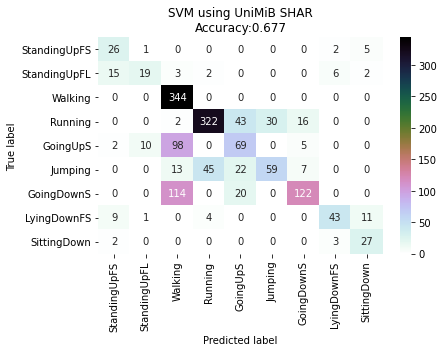

In [18]:
y_pred = model.predict(X_test_vectors)

# Print prediction accuracy
print('Prediction accuracy: {0:.3f}'.format(accuracy_score(y_test, y_pred)))

# Print a report of classification performance metrics
print(classification_report(y_test, y_pred, target_names=t_names))

# Plot a confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm,
                     index = t_names, 
                     columns = t_names)
fig = plt.figure(figsize=(6.5,5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='cubehelix_r')
plt.title('SVM using '+dataset+'\nAccuracy:{0:.3f}'.format(accuracy_score(y_test, y_pred)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout() # keeps labels from being cutoff when saving as pdf
plt.show()

# For comparison, train at test a Random Forest Classifier

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    3.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


Prediction accuracy: 0.685
              precision    recall  f1-score   support

StandingUpFS       0.56      0.68      0.61        34
StandingUpFL       0.63      0.51      0.56        47
     Walking       0.61      0.92      0.73       344
     Running       0.85      0.86      0.86       413
    GoingUpS       0.57      0.44      0.50       184
     Jumping       1.00      0.41      0.58       146
  GoingDownS       0.58      0.48      0.53       256
 LyingDownFS       0.70      0.66      0.68        68
 SittingDown       0.52      0.53      0.52        32

    accuracy                           0.69      1524
   macro avg       0.67      0.61      0.62      1524
weighted avg       0.70      0.69      0.67      1524



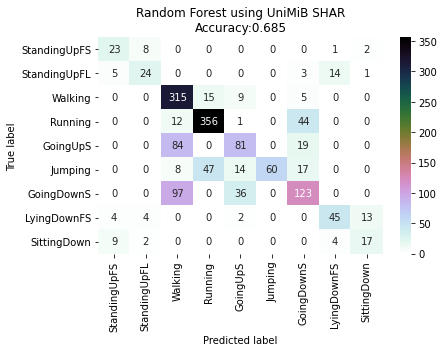

In [21]:
# Train a Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(class_weight='balanced', n_estimators=200)
model.fit(X_train_vectors, y_train)

X_test_vectors = test_feat_vectors.to_numpy()
y_pred = model.predict(X_test_vectors)

# Print prediction accuracy
print('Prediction accuracy: {0:.3f}'.format(accuracy_score(y_test, y_pred)))

# Print a report of classification performance metrics
print(classification_report(y_test, y_pred, target_names=t_names))

# Plot a confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm,
                     index = t_names, 
                     columns = t_names)
fig = plt.figure(figsize=(6.5,5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='cubehelix_r')
plt.title('Random Forest using '+dataset+'\nAccuracy:{0:.3f}'.format(accuracy_score(y_test, y_pred)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout() # keeps labels from being cutoff when saving as pdf
plt.show()